# Final Project: Correlation between Starbucks Location Amount Per Zipcode and Income of the Area

### Group Member PIDs:

- A12347131
- A12026074
- A12025800
- A11367317
- A12326499

## Introduction and Background

### Research Question

Our research question is focused around the amount of Starbucks in relation to the income areas around the US. Specifically, what is the nature of the correlation between the income of a zipcode and the amount Starbucks in that zipcode?

### Hypothesis

Our prediction would be that there would be a positive correlation between income and location numbers. Starbucks is known as a more expensive coffee chain, and as such a higher income would theoretically be needed in order to afford purchasing on a daily/weekly basis. Thus, if our results indicate a relationship we should be able to predict whether one zipcode would more likely have more Starbucks locations than another zipcode based solely on income. 

### Background and Prior Work

In our background work, one of the references we found was a strategic analysis of Starbucks done at Harvard. In it, they note that Starbucks prides itself on the high quality and experience that it brings to its customers. Thus, this is why Starbucks needs to be a bit higher priced than that of its competitors. Since it needs to distinguish itself, it needs to have these higher prices. In order to sustain these higher prices though they need enough people to purchase it. This is why we theorize there are more in the higher income areas. Only the higher income customers would be able to support multiple establishments around them. When looking to see if anyone had done major research on this previously, one thing that we were able to find was a map created that plotted all of the Starbucks locations on it with incomes as well. Though visually, it seems that there are more locations in areas with higher incomes, no actually tests were performed. This was simply just a qualitative example showing that there are higher clusters of locations around these high income areas. Though there may be another explanation that the higher income areas are more rural areas, there was no test to see whether income and amount were actually correlated. This is an important question because it would let Starbucks know if there were any areas that should have more locations next to it. If there are outliers or amounts of locations that fell below the predicted amount, it might be possible that more stores could be added in that area that would be able to be sustained, given that they acted like the other areas similar in income to it.

References: 
- Harvard - Strategic Analysis of Starbucks Corporation https://scholar.harvard.edu/files/nithingeereddy/files/starbucks_case_analysis.pdf 
- Observational Map - Income Level and Location 
https://www.arcgis.com/home/webmap/viewer.html?webmap=c4199423e294410286d3e22b71a6b3cc

In [1]:
#Imports
 
import numpy as np
import pandas as pd
from pandas.tools.plotting import scatter_matrix
import matplotlib.pyplot as plt
import patsy
import statsmodels.api as sm
from scipy.stats import ttest_ind
from scipy.cluster.vq import whiten

## Data Description

### Datasets

Starbucks: 
- Dataset Name: All Starbucks Locations in the World 
- Link to Dataset: https://www.kaggle.com/starbucks/store-locations 
- Number of observations: 25,150 (13,500 in the US) 
- This data set maps all the Starbucks in the world. The set looks at their name, phone number, zip code, store number, ownership type, street, city, country, and coordinates.
- 'Starbucks.csv'

Income: 
- Dataset Name: SOI Tax Stats 
- Individual Income Tax Statistics 
- 2014 ZIP Code Data (SOI) 
- Link: https://www.irs.gov/uac/soi-tax-stats-individual-income-tax-statistics-2014-zip-code-data-soi 
    - Download the file w/o the agi
- Number of observations: 166,687 
- Looks at all the household incomes of the country by Zip Code based on people’s tax returns
- 'Income.csv'

## Data Cleaning / Pre-Processing

Reading in the files and making them into pandas dataframes

In [2]:
locations_csv = 'Starbucks.csv'
sb_df = pd.read_csv(locations_csv)
 
incomes_csv = 'Income.csv'
inc_df = pd.read_csv(incomes_csv)
print(sb_df.head(5))
print(inc_df.head(5))

       Brand  Store Number        Store Name Ownership Type  \
0  Starbucks  47370-257954     Meritxell, 96       Licensed   
1  Starbucks  22331-212325  Ajman Drive Thru       Licensed   
2  Starbucks  47089-256771         Dana Mall       Licensed   
3  Starbucks  22126-218024        Twofour 54       Licensed   
4  Starbucks  17127-178586      Al Ain Tower       Licensed   

                    Street Address              City State/Province Country  \
0                Av. Meritxell, 96  Andorra la Vella              7      AD   
1             1 Street 69, Al Jarf             Ajman             AJ      AE   
2     Sheikh Khalifa Bin Zayed St.             Ajman             AJ      AE   
3                  Al Salam Street         Abu Dhabi             AZ      AE   
4  Khaldiya Area, Abu Dhabi Island         Abu Dhabi             AZ      AE   

  Postcode Phone Number                 Timezone  Longitude  Latitude  
0    AD500    376818720  GMT+1:00 Europe/Andorra       1.53     42.51  
1 

Next we reduced the Dataframes to just the columns that we needed. 

For the Starbucks file this was just the rows that included the locations in the US, and then only the Zipcode column is needed. Each row represents one location. 

For the income file, we reduced it to the Zipcode column, as well as the column titled AO4800 which is the taxable income for that area.

In [3]:
sb_df = sb_df[sb_df.Country == 'US']
sb_df = sb_df[['Postcode']]
 
inc_df = inc_df[['ZIPCODE', 'A04800']]
print(sb_df.head(5))
print(inc_df.head(5))

        Postcode
11964  995042300
11965  995073444
11966  995153596
11967      99515
11968  995152050
   ZIPCODE      A04800
0        0  71406969.0
1    35004    174934.0
2    35005     71144.0
3    35006     37333.0
4    35007    447297.0


Then we took all of the Zipcodes in the Starbucks files and made sure that it was only the first five digits. Some of the Zipcodes had the extra four digits for more specific regions, but the income file does not have these, and as such we trimmed it down to only the first five digits. 

In [4]:
for zip_code in sb_df['Postcode']:
    zip_code = str(zip_code)
    sb_df.loc[sb_df['Postcode'] == zip_code] = zip_code[:5]
print(sb_df.head(5))

      Postcode
11964    99504
11965    99507
11966    99515
11967    99515
11968    99515


We renamed the A04800 column in the Income Dataframe to income in order to make it easier to work with as well as labelling it correctly.

In [5]:
inc_df.rename(columns={'A04800' : 'income'}, inplace=True)
print(inc_df.head(5))

   ZIPCODE      income
0        0  71406969.0
1    35004    174934.0
2    35005     71144.0
3    35006     37333.0
4    35007    447297.0


Since we are interesting the amount of locations per zipcode, we then wrote code in order to count how many locations were in each zipcode and saved that into a new dataframe.

In [6]:
sb_nums = sb_df['Postcode'].value_counts()
sb_zipkeys = sb_nums.keys()
sb_zipkeys = sb_zipkeys.to_series()
for i, val in sb_zipkeys.iteritems():
    sb_zipkeys[i] = int(val)
sb_locs = pd.concat([sb_nums, sb_zipkeys], axis = 1)
sb_locs.rename(columns={'Postcode': 'AMOUNT'}, inplace=True)
sb_locs.rename(columns={0: 'ZIPCODE'}, inplace=True)
print(sb_locs.head(5))

       AMOUNT ZIPCODE
89109      32   89109
98101      24   98101
90045      21   90045
10019      20   10019
92101      20   92101


Then we merged the dataframe of Starbucks locations amounts with the dataframe of incomes, so that we had three columns: zipcode, amount of Starbucks locations in that zipcode, and the taxable income of that zipcode.

In [7]:
new_df = pd.merge(inc_df, sb_locs, how='inner', on='ZIPCODE')
print(new_df.head(5))

   ZIPCODE    income  AMOUNT
0    35007  447297.0       3
1    35022  343115.0       1
2    35055  243148.0       1
3    35068  109665.0       1
4    35071  282756.0       1


We then attempted to normalize the data. We also took the natural log of the income in order to make it more left oriented rather than right oriented. In addition, it was an attempt to make the data less skewed. 

In [8]:
new_df.income = np.log10(new_df.income)
new_df['income']= (new_df['income']-new_df['income'].mean())/(new_df['income'].max()-new_df['income'].min())
new_df['AMOUNT']= (new_df['AMOUNT']-new_df['AMOUNT'].mean())/(new_df['AMOUNT'].max()-new_df['AMOUNT'].min())

## Data Visualization


After cleaning the data, we will explore data visualization to understand our data better. We plot the data, using scatter_matrix with Pandas. We will call the variable "scatter".

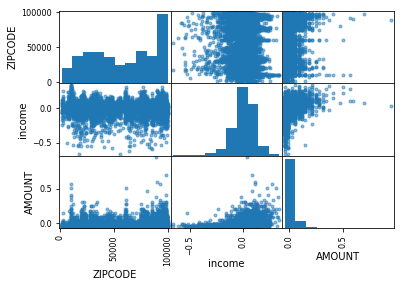

In [9]:
plt.figure()
scatter = pd.scatter_matrix(new_df)
plt.show()


Now we will make a more specific scatter plot with Income in a zip code area as our y-axis and the amount of Starbucks on the x-axis: We plot the data, using scatter_matrix with Pandas. We will call this new variable "scatter2".

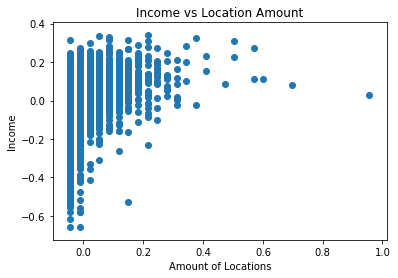

In [10]:
plt.figure()
scatter2 = plt.scatter(new_df.AMOUNT, new_df.income)
plt.title('Income vs Location Amount')
plt.xlabel('Amount of Locations')
plt.ylabel('Income')
plt.show()


## Data Analysis and Results


### Analysis

We will analyze our data and continue to explore our hypothesis to see if there is a relationship between the income of a zipcode and the amount Starbucks in that zipcode. We plot the data, using "scatter2" with the line of best fit. 

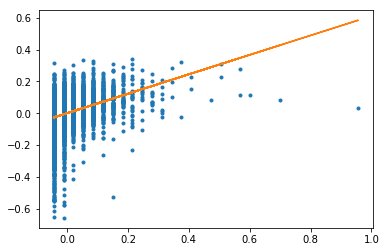

In [11]:
x = new_df.AMOUNT
y = new_df.income
 
m, b = np.polyfit(x, y, 1)
 
plt.plot(x, y, '.')
plt.plot(x, m*x + b, '-')
plt.show()


### Results

Now proceed to using Ordinary Least Squares as we will make linear models. We create a linear model to use the toal location of Starbucks to predict inome (using df_new as data). From patsy we can design matrices and use that to create an OLS model. Then we will fit the model and then look at the results afterwards

In [12]:
outcome, predictors = patsy.dmatrices('income ~ AMOUNT', new_df)
mod = sm.OLS(outcome, predictors)
res = mod.fit()



In [13]:
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:                 income   R-squared:                       0.119
Model:                            OLS   Adj. R-squared:                  0.118
Method:                 Least Squares   F-statistic:                     742.6
Date:                Tue, 13 Jun 2017   Prob (F-statistic):          1.61e-153
Time:                        16:34:59   Log-Likelihood:                 4649.6
No. Observations:                5522   AIC:                            -9295.
Df Residuals:                    5520   BIC:                            -9282.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
Intercept   1.452e-15      0.001   1.03e-12      1.0

Based on our model (with alpha value of 0.05), there is a positive correlation between the amount of Starbucks stores in a zip code and the income of that zip code.
This will help us find if the p value signifies that the result is not due to chance. 

In [14]:
p=res.pvalues[1]

if p < 0.05:
    lm=True
else:
    lm=False
 
print(lm)


True


## Discussions and Conclusions

### Conclusion

From running the OLS regression line, we have found that there is a positive correlation between income and Starbucks amount. This means that in general, as the income of a zipcode increases, the amount of Starbucks locations tends to increase as well.  Since we had a p value less than our alpha of .05, this means that there is a less than 5% chance that this result was just due to random chance. However, due to our positive correlation being weak, we cannot say that the income and amount of Starbucks predict each other. We can simply say that there is a general correlation between the two, not a causal relationship.

### Discussion

Starbucks would be able to use these results to help them expand their business. Since there is a positive correlation between income and current locations, they could look to zipcodes where there are few locations and using these results determine if it would be feasible to add any more. If the current amount of locations seems to be below the average amount for other zipcodes with the same income, then they could reasonably add more locations. The correlation between income and amount of stores is not too strong and a possible explanation for this is that Starbucks is competing with other popular coffee chains such as Philz Coffee, which appeals to an even higher income crowd than that of Starbucks. This would mean that the higher income areas would have a conflicting variable in the case of this chain, as customers may be going to Philz instead of Starbucks for their coffee.